# Understanding Semantic Segmentation with UNET

Article Reference:\
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

In [1]:
# IMPORT LIBRARIES

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import tqdm_notebook, trange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import concatenate
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Concatenate, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img


2022-10-03 17:35:51.249118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 17:35:51.503399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-10-03 17:35:51.503417: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-03 17:35:51.538788: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10

In [2]:
# PARAMETER DEFINITION

# Data Directory Paths
DATA_ROOT_DIR_PATH='../../data/tgs-salt/'
TRAIN_IMAGES_DIR_PATH='train/images'
TEST_IMAGES_DIR_PATH='test/images'
TRAIN_MASKS_DIR_PATH='train/masks'
TEST_MASKS_DIR_PATH='test/masks'

# Parameters
IM_WIDTH = 128
IM_HEIGHT = 128
BORDER = 5

train_images_path = os.path.join(DATA_ROOT_DIR_PATH, TRAIN_IMAGES_DIR_PATH)
test_images_path = os.path.join(DATA_ROOT_DIR_PATH, TEST_IMAGES_DIR_PATH)
train_masks_path = os.path.join(DATA_ROOT_DIR_PATH, TRAIN_MASKS_DIR_PATH)
test_masks_path = os.path.join(DATA_ROOT_DIR_PATH, TEST_MASKS_DIR_PATH)

print(f'Data Directory Paths:\
      \nTrain images path: {train_images_path}\
      \nTest images path:  {test_images_path}\
      \nTrain masks path:  {train_masks_path}\
      \nTest masks path:   {test_masks_path}')

Data Directory Paths:      
Train images path: ../../data/tgs-salt/train/images      
Test images path:  ../../data/tgs-salt/test/images      
Train masks path:  ../../data/tgs-salt/train/masks      
Test masks path:   ../../data/tgs-salt/test/masks


In [3]:
def get_files_from_path(path):
    return next(os.walk(path))[2]

files = get_files_from_path(train_images_path)
print(f'Total number of image files: {len(train_images_path)}')

Total number of image files: 32


In [4]:
def generate_4d_empty_matrix(data_lenght, im_height=IM_HEIGHT, im_width=IM_WIDTH):
    return np.zeros((data_lenght, im_height, im_width, 1), dtype=np.float32)

X = generate_4d_empty_matrix(len(files))
y = generate_4d_empty_matrix(len(files))

print(f'X: {X.shape}\nY: {y.shape}')   

X: (4000, 128, 128, 1)
Y: (4000, 128, 128, 1)


In [5]:
def get_and_resize_images_from_path(image_path, mask_path, im_height=IM_HEIGHT, im_width=IM_WIDTH, train=True):
    files = next(os.walk(image_path))[2]
    for n, file in enumerate(files):
        img = load_img(os.path.join(image_path, file), color_mode="grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            mask = img_to_array(load_img(os.path.join(mask_path, file), grayscale=True))
            mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)
            y[n] = mask / 255
    return X, y

X, y = get_and_resize_images_from_path(train_images_path, train_masks_path)

print(f'X: {X.shape}\ny: {y.shape}')

/home/hasier/anaconda3/envs/img-seg/lib/python3.8/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


X: (4000, 128, 128, 1)
y: (4000, 128, 128, 1)


In [6]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

print(f'X_train: {X_train.shape}\nX_valid: {X_valid.shape}\
      \ny_train: {y_train.shape}\ny_valid: {y_valid.shape}')

X_train: (3400, 128, 128, 1)
X_valid: (600, 128, 128, 1)      
y_train: (3400, 128, 128, 1)
y_valid: (600, 128, 128, 1)


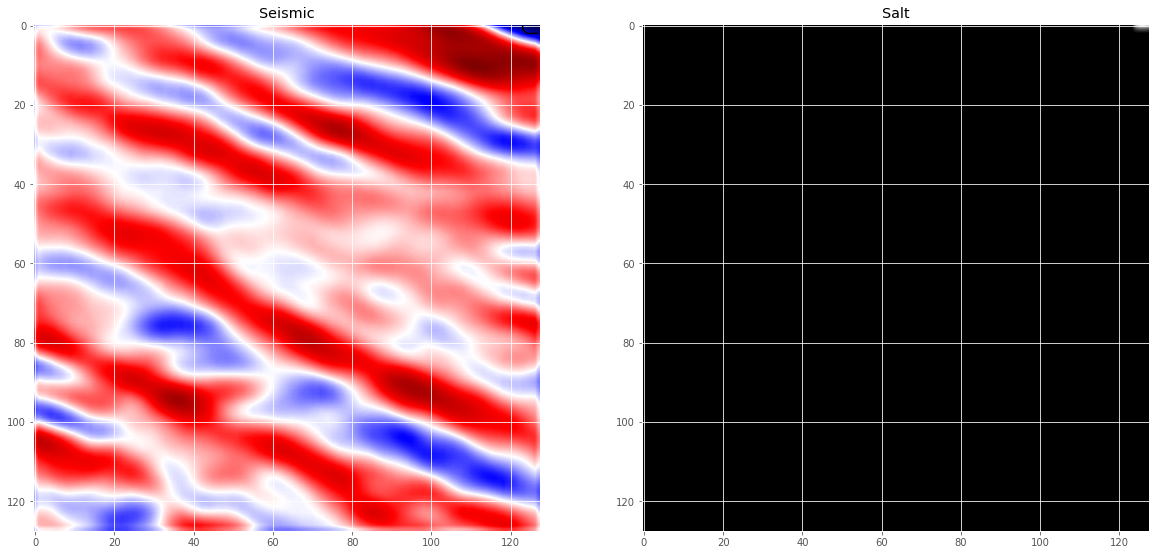

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');


# UNET model
A successful and popular model for these kind of problems is the UNet architecture. The network architecture is illustrated in Figure 1. It consists of a contracting path (left side) and an expansive path (right side).

 - The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3×33\times33×3 convolutions, each followed by a batchnormalization layer and a rectified linear unit (ReLU) activation and dropout and a 2×22\times22×2 max pooling operation with stride 222 for downsampling. At each downsampling step we double the number of feature channels. The purpose of this contracting path is to capture the context of the input image in order to be able to do segmentation.
 - Every step in the expansive path consists of an upsampling of the feature map followed by a 2×22\times22×2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly feature map from the contracting path, and two 3×33\times33×3 convolutions, each followed by batchnorm, dropout and a ReLU. The purpose of this expanding path is to enable precise localization combined with contextual information from the contracting path.
 - At the final layer a 1×11\times11×1 convolution is used to map each 161616-component feature vector to the desired number of classes.
 
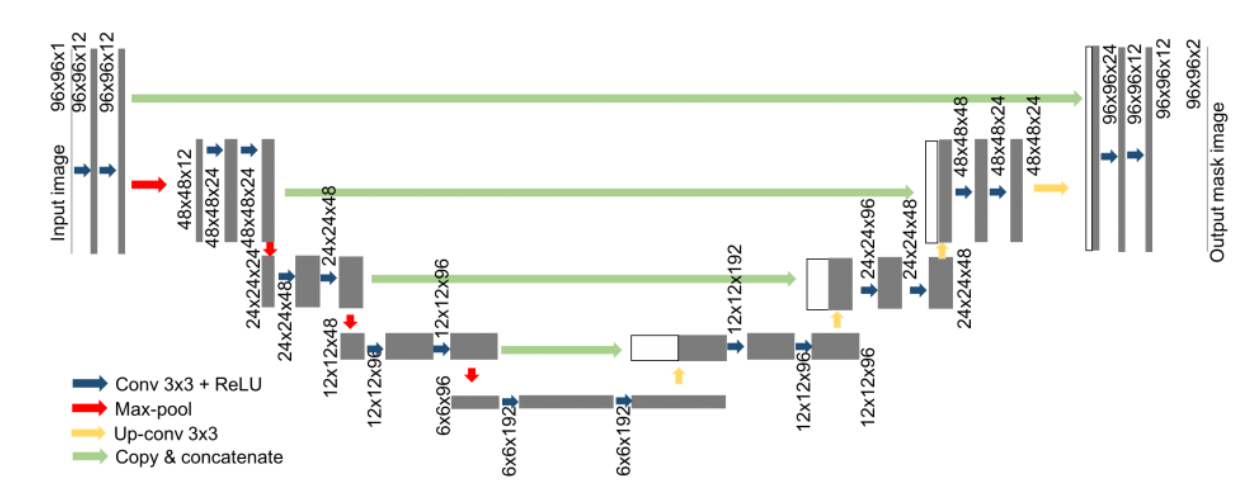

In [8]:
# Defining UNET model
# NOTE: In the function "conv2d_block" were an error.
# The input of second convolutional layer must be the output of the first one. 

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [9]:
input_img = Input((IM_HEIGHT, IM_WIDTH, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


2022-09-28 11:59:53.788744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 11:59:53.789771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-09-28 11:59:53.789840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-09-28 11:59:53.789893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [11]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))


Epoch 1/100


2022-09-28 11:59:54.211710: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 222822400 exceeds 10% of free system memory.
2022-09-28 11:59:54.284815: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 222822400 exceeds 10% of free system memory.
2022-09-28 11:59:56.208083: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2022-09-28 11:59:56.220093: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2022-09-28 11:59:56.241894: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.


 24/107 [=====>........................] - ETA: 2:33 - loss: -70.6095 - accuracy: 0.3590

KeyboardInterrupt: 